# Testing the conditional layer without MAML

In [1]:
#import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import matplotlib.pyplot as plt
from collections import OrderedDict

sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
from pytorchtools import EarlyStopping

In [2]:

dataset_name = "HR"
dataset_name = "POLLUTION"
window_size = 32
window_size = 5
task_size = 50
batch_size = 64
input_dim = 13
input_dim = 14
output_dim = 1
hidden_dim = 120


In [3]:
train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [4]:
def get_task_encoder_input(data_ML):
    
    task_encoder_input = np.concatenate((data_ML.x[:,:,0,:], data_ML.y), axis=2)
    
    return task_encoder_input


   
class LSTMDecoder(nn.Module):
    
    def __init__(self, batch_size, seq_len, output_dim, n_layers, hidden_dim, latent_dim, device):
        
        super(LSTMDecoder, self).__init__()
        
        self.batch_size = batch_size
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.sequence_length = seq_len
        
        self.lstm = nn.LSTM(1, hidden_dim, n_layers, batch_first=True)
        
        self.latent_to_hidden = nn.Linear(self.latent_dim, self.hidden_dim)
        self.hidden_to_output = nn.Linear(self.hidden_dim, self.output_dim)
        
    
        self.decoder_inputs = torch.zeros( self.batch_size, self.sequence_length, 1, requires_grad=True).to(device)
        self.c_0 = torch.zeros(self.n_layers, self.batch_size, self.hidden_dim, requires_grad=True).to(device)

        nn.init.xavier_uniform_(self.latent_to_hidden.weight)
        nn.init.xavier_uniform_(self.hidden_to_output.weight)
        
        self.to(device)
        
        
    def forward(self, latent):
        
        h_state = self.latent_to_hidden(latent).unsqueeze(0)
        h_0 = torch.cat([h_state for _ in range(self.n_layers)], axis=0)
        decoder_output, _ = self.lstm(self.decoder_inputs, (h_0, self.c_0))
        out = self.hidden_to_output(decoder_output)
        
        return out
    



class Lambda(nn.Module):

    """Lambda module converts output of encoder to latent vector

    :param hidden_size: hidden size of the encoder
    :param latent_length: latent vector length
    https://github.com/abhmalik/timeseries-clustering-vae/blob/master/vrae/vrae.py

    """

    def __init__(self, hidden_dim, latent_dim):

        super(Lambda, self).__init__()

        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.hidden_to_mean = nn.Linear(self.hidden_dim, self.latent_dim)
        self.hidden_to_logvar = nn.Linear(self.hidden_dim, self.latent_dim)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)


    def forward(self, cell_output):

        """Given last hidden state of encoder, passes through a linear layer, and finds the mean and variance

        :param cell_output: last hidden state of encoder
        :return: latent vector

        """

        self.latent_mean = self.hidden_to_mean(cell_output)
        self.latent_logvar = self.hidden_to_logvar(cell_output)

        if self.training:
            std = torch.exp(0.5 * self.latent_logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(self.latent_mean)
        else:
            return self.latent_mean


In [5]:
#paramters wto increase capactiy of the model
n_layers_task_net = 2
n_layers_task_encoder = 1
n_layers_task_decoder = 1

hidden_dim_task_net = 120
hidden_dim_encoder = 120
hidden_dim_decoder = 120

#fixed values
input_dim_task_net = input_dim
input_dim_task_encoder = input_dim +1 
output_dim_task_net = 1
output_dim_task_decoder = input_dim+1

        
total_tasks = len(train_data_ML)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



class MultimodalLearner(nn.Module):
    
    def __init__(self, task_net, task_encoder, task_decoder, lmbd):
        
        super(MultimodalLearner, self).__init__()
        
        self.task_net = task_net
        self.task_encoder = task_encoder
        self.task_decoder = task_decoder
        self.lmbd = lmbd
        self.modulation_layer = nn.Linear(task_encoder.hidden_dim, task_net.hidden_dim*2)
        self.output_layer = nn.Linear(task_net.hidden_dim, 1)
        self.task_decoder = task_decoder
        self.rec_loss = nn.SmoothL1Loss(size_average=False)
    
    
    def conditional_layer(self, x, embedding):
        
        ###apply by deffault the affine transformation -- FiLM layer
        
        gammas, betas = torch.split(embedding, x.size(1), dim=-1)
        gammas = gammas + torch.ones_like(gammas)
        x = x*gammas + betas
        
        return x

    def compute_loss(self, x_decoded, x):
        
        
        latent_mean, latent_logvar = self.lmbd.latent_mean, self.lmbd.latent_logvar
        kl_loss = -0.5 * torch.mean(1 + latent_logvar - latent_mean.pow(2) - latent_logvar.exp())
        recon_loss = self.rec_loss(x_decoded, x)
        
        return recon_loss + kl_loss, kl_loss, recon_loss
    
    def forward (self, x, task, params=None, embeddings=None):
        
        if params is None:
            params = OrderedDict(self.named_parameters())
            
        x = self.task_net.encoder(x)
        encoding = self.task_encoder.encoder(task)
        latent = self.lmbd(encoding)
        task_rec = self.task_decoder(latent)
        
        modulation_embeddings = self.modulation_layer(encoding)
        modulated_output = self.conditional_layer(x, modulation_embeddings)
        output = self.output_layer(modulated_output)
        
        loss = self.compute_loss(task_rec, task)
        
        return output, loss

 

In [6]:
def test(data_ML, multimodal_learner, loss_fn):
    
    total_tasks, task_size, window_size, input_dim = data_ML.x.shape
    
    task_data = torch.FloatTensor(get_task_encoder_input(data_ML))
    x_tensor = torch.FloatTensor(data_ML.x)
    y_tensor = torch.FloatTensor(data_ML.y) 

    count = 0.0
    accum_loss = 0.0
    
    for task_id in range(0, total_tasks, total_tasks//100):
        
        task =task_data[task_id:task_id+1].cuda()
        x = x_tensor[task_id+1].cuda()
        y = y_tensor[task_id+1].cuda()

        y_pred, (vrae_loss, kl_loss, rec_loss) = multimodal_learner(x, task)

        loss = loss_fn(y_pred, y)
        accum_loss += loss.cpu().detach().numpy()
        count +=1
        
    return accum_loss/count
        


task_net = LSTMModel(batch_size=batch_size, 
                       seq_len = window_size, 
                       input_dim = input_dim_task_net, 
                       n_layers = n_layers_task_net, 
                       hidden_dim = hidden_dim_task_net, 
                       output_dim = output_dim_task_net)

task_encoder = LSTMModel(batch_size=batch_size, 
                         seq_len = task_size, 
                         input_dim = input_dim_task_encoder, 
                         n_layers = n_layers_task_encoder, 
                         hidden_dim = hidden_dim_encoder, 
                         output_dim =1)

task_decoder = LSTMDecoder(batch_size = 1, 
                           n_layers = n_layers_task_decoder , 
                           seq_len = task_size, 
                           output_dim = output_dim_task_decoder, 
                           hidden_dim = hidden_dim_encoder, 
                           latent_dim = hidden_dim_decoder, 
                           device = device)

lmbd = Lambda(hidden_dim_encoder, hidden_dim_task_net)

multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd)
multimodal_learner.to(device)

opt = torch.optim.Adam(multimodal_learner.parameters(), lr = 0.0001)

task_data = torch.FloatTensor(get_task_encoder_input(train_data_ML))
x_tensor = torch.FloatTensor(train_data_ML.x)
y_tensor = torch.FloatTensor(train_data_ML.y)

epochs = 5000

loss_fn = nn.SmoothL1Loss(size_average=False)
#loss_fn = mae

val_loss_hist = []
test_loss_hist = []

for epoch in range(epochs):

    multimodal_learner.train()
    
    task_id = np.random.randint(0, total_tasks)
    #or task_id in range(total_tasks-1):
    task =task_data[task_id:task_id+1].cuda()
    x = x_tensor[task_id+1].cuda()
    y = y_tensor[task_id+1].cuda()

    y_pred, (vrae_loss, kl_loss, rec_loss) = multimodal_learner(x, task)

    loss = loss_fn(y_pred, y) + vrae_loss

    opt.zero_grad()
    loss.backward()

    opt.step()

    if task_id %100 == 0:

        print("Loss this time:", loss)
    
    multimodal_learner.eval()
    with torch.no_grad():
        val_loss = test(validation_data_ML, multimodal_learner, mae)
        test_loss = test(test_data_ML, multimodal_learner, mae)
    
    print("Epoch:", epoch)
    print("Train loss:",loss)
    print("Val loss:", val_loss)
    print("Test loss:", test_loss)
    
    val_loss_hist.append(val_loss)
    test_loss_hist.append(test_loss)

C:\Users\VWG3APX\AppData\Roaming\Python\Python37\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0
Train loss: tensor(137.8291, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.10034741611175593
Test loss: 0.13116203178421104
Epoch: 1
Train loss: tensor(295.0791, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.0950062658504716
Test loss: 0.12437941926983323
Epoch: 2
Train loss: tensor(482.3102, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.08995051254917469
Test loss: 0.11784783341359384
Epoch: 3
Train loss: tensor(101.6671, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.0850523332311284
Test loss: 0.11164504201105326
Epoch: 4
Train loss: tensor(314.3843, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.08016593380875531
Test loss: 0.10535934998995007
Epoch: 5
Train loss: tensor(172.1096, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.07578379501189504
Test loss: 0.09970334620390198
Epoch: 6
Train loss: tensor(192.2949, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.0714958704564543
Test loss: 0.09437421117309887
Epoch: 7
Train loss: te

Train loss: tensor(221.5992, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03663891919312023
Test loss: 0.04607353486710846
Loss this time: tensor(310.5414, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 58
Train loss: tensor(310.5414, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03562309459916183
Test loss: 0.04537877073456155
Epoch: 59
Train loss: tensor(119.9283, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03486887569583598
Test loss: 0.044872102051014356
Epoch: 60
Train loss: tensor(176.0481, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.034412494488060476
Test loss: 0.04460362335759224
Epoch: 61
Train loss: tensor(166.3115, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03401348026735442
Test loss: 0.044385007693257074
Epoch: 62
Train loss: tensor(208.2957, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03404702906097685
Test loss: 0.04438117022008294
Epoch: 63
Train loss: tensor(384.1505, device='cuda:0', grad_fn=<AddBackward0>)
Val los

Epoch: 114
Train loss: tensor(140.8803, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03639985510103759
Test loss: 0.04447941759619677
Epoch: 115
Train loss: tensor(172.1575, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03640673548160564
Test loss: 0.044413094666998575
Epoch: 116
Train loss: tensor(264.0615, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03627812550181434
Test loss: 0.04418956611932504
Epoch: 117
Train loss: tensor(125.5586, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03617619339908872
Test loss: 0.04401427158846123
Epoch: 118
Train loss: tensor(288.2826, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.036167434301404726
Test loss: 0.043956309593845125
Epoch: 119
Train loss: tensor(169.7174, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03619150503405503
Test loss: 0.04393365814138462
Epoch: 120
Train loss: tensor(171.6795, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.036216007669766744
Test loss: 0.04391515576787809
Ep

Train loss: tensor(136.0705, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03735593787970997
Test loss: 0.04364245582261298
Epoch: 171
Train loss: tensor(139.8520, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03731314927516949
Test loss: 0.04358037960448182
Epoch: 172
Train loss: tensor(121.0685, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.037276178633882884
Test loss: 0.04352693085438839
Epoch: 173
Train loss: tensor(155.1184, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03724304164449374
Test loss: 0.043472202771370955
Epoch: 174
Train loss: tensor(167.5544, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03721808345012721
Test loss: 0.0434308761620138
Epoch: 175
Train loss: tensor(195.0032, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03718262483321485
Test loss: 0.04340668653350065
Epoch: 176
Train loss: tensor(319.7758, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03715599950935159
Test loss: 0.04334225917769836
Epoch: 177
Train

Train loss: tensor(195.2752, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04031934079137586
Test loss: 0.04254485347704722
Epoch: 228
Train loss: tensor(134.0855, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.040005426215274
Test loss: 0.04244836732413214
Epoch: 229
Train loss: tensor(153.6152, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.039727457914324034
Test loss: 0.042368689349087156
Epoch: 230
Train loss: tensor(414.7127, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03958498726465872
Test loss: 0.0423505324870348
Epoch: 231
Train loss: tensor(135.5213, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03947128928488209
Test loss: 0.04236232937488815
Epoch: 232
Train loss: tensor(102.4038, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03936531612915652
Test loss: 0.04235287004214997
Epoch: 233
Train loss: tensor(370.9610, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03929427975700015
Test loss: 0.042369055285090856
Epoch: 234
Train 

Val loss: 0.04013005609491042
Test loss: 0.044219413117533274
Epoch: 285
Train loss: tensor(177.1803, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.0402926084275047
Test loss: 0.04458517809905628
Epoch: 286
Train loss: tensor(152.2399, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.040406783412964574
Test loss: 0.044804127601039884
Epoch: 287
Train loss: tensor(105.1799, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04052024618500755
Test loss: 0.04499418751364297
Epoch: 288
Train loss: tensor(152.9129, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04063409399241209
Test loss: 0.04515962959221094
Epoch: 289
Train loss: tensor(151.0469, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.041013307017939434
Test loss: 0.04570707596727822
Epoch: 290
Train loss: tensor(178.2853, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04138179559792791
Test loss: 0.04621331371588282
Epoch: 291
Train loss: tensor(480.0519, device='cuda:0', grad_fn=<AddBackward0>)
Val

Epoch: 342
Train loss: tensor(157.5410, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03961665440528166
Test loss: 0.04390900099816004
Epoch: 343
Train loss: tensor(164.0153, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03959180724230551
Test loss: 0.043934597098960144
Epoch: 344
Train loss: tensor(113.8255, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03956882796649422
Test loss: 0.04396069404844305
Epoch: 345
Train loss: tensor(151.3284, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03955440700408958
Test loss: 0.0439990039656658
Epoch: 346
Train loss: tensor(142.5509, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03954339169320606
Test loss: 0.04403550935780058
Epoch: 347
Train loss: tensor(95.0402, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03951014826695124
Test loss: 0.044051324118777074
Epoch: 348
Train loss: tensor(169.4485, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.039418409463195574
Test loss: 0.04395414033148548
Epoch

Val loss: 0.040268139567758356
Test loss: 0.04739717423620791
Epoch: 400
Train loss: tensor(165.8758, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03978956455276126
Test loss: 0.04656616388128536
Epoch: 401
Train loss: tensor(148.8982, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.039408065516146874
Test loss: 0.04586531306699951
Epoch: 402
Train loss: tensor(125.5869, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.039088196657775416
Test loss: 0.04527456516234001
Epoch: 403
Train loss: tensor(301.0201, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.038749689675335375
Test loss: 0.044567319241785766
Epoch: 404
Train loss: tensor(167.2153, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03850422385813934
Test loss: 0.04404433000611492
Epoch: 405
Train loss: tensor(133.5910, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03834624546358273
Test loss: 0.04368532249833097
Epoch: 406
Train loss: tensor(114.9476, device='cuda:0', grad_fn=<AddBackward0>)
V

Val loss: 0.04934207208986793
Test loss: 0.05519266551969075
Epoch: 457
Train loss: tensor(166.0591, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05024327163007997
Test loss: 0.05448391312493546
Epoch: 458
Train loss: tensor(180.6655, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.051876849867403506
Test loss: 0.05487874417685636
Epoch: 459
Train loss: tensor(96.6994, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05384481998958758
Test loss: 0.05595012792930155
Epoch: 460
Train loss: tensor(143.6020, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05479830023610876
Test loss: 0.05644738368026101
Epoch: 461
Train loss: tensor(211.2924, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05618538760713169
Test loss: 0.057515606948054666
Epoch: 462
Train loss: tensor(129.2929, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05650759259504931
Test loss: 0.057835259963527764
Epoch: 463
Train loss: tensor(197.5170, device='cuda:0', grad_fn=<AddBackward0>)
Val 

Train loss: tensor(268.4503, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05543059121285166
Test loss: 0.06282180750576577
Epoch: 515
Train loss: tensor(184.2916, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05510608835057134
Test loss: 0.06144742571776456
Epoch: 516
Train loss: tensor(205.9417, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.053906197845935824
Test loss: 0.05966778401986207
Epoch: 517
Train loss: tensor(209.8744, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.052348540448361916
Test loss: 0.0577556390757903
Epoch: 518
Train loss: tensor(151.1579, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.050191440459873
Test loss: 0.055552092094970223
Epoch: 519
Train loss: tensor(171.6421, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.047821112234322796
Test loss: 0.05278882889611886
Epoch: 520
Train loss: tensor(120.6462, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04533014642518191
Test loss: 0.050187358807883053
Epoch: 521
Trai

Val loss: 0.043355350533411614
Test loss: 0.04776946178609782
Epoch: 572
Train loss: tensor(112.8836, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04400494366529442
Test loss: 0.04862026566879289
Epoch: 573
Train loss: tensor(472.5701, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04706795769965365
Test loss: 0.053617153685576846
Epoch: 574
Train loss: tensor(248.2354, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04939961831661917
Test loss: 0.05738683188758274
Epoch: 575
Train loss: tensor(141.1038, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.051741032674908635
Test loss: 0.06122293021751217
Epoch: 576
Train loss: tensor(124.4345, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.054945254636307554
Test loss: 0.0659218192155851
Epoch: 577
Train loss: tensor(135.4612, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.058345155803752796
Test loss: 0.07057758809832654
Epoch: 578
Train loss: tensor(193.3671, device='cuda:0', grad_fn=<AddBackward0>)
Va

Train loss: tensor(168.8291, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04421177411540633
Test loss: 0.05648014083098952
Epoch: 630
Train loss: tensor(133.9821, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04346287034097172
Test loss: 0.05564922193932061
Epoch: 631
Train loss: tensor(113.3314, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.0426040715005781
Test loss: 0.05460360240523178
Epoch: 632
Train loss: tensor(163.5586, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04179890822796595
Test loss: 0.053614225837927645
Epoch: 633
Train loss: tensor(175.8529, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04116592779755592
Test loss: 0.05282118341120163
Epoch: 634
Train loss: tensor(123.6397, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04017519384533876
Test loss: 0.05158862826589605
Epoch: 635
Train loss: tensor(145.5780, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03948927421034092
Test loss: 0.05063730809321203
Epoch: 636
Train 

Train loss: tensor(257.8187, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03507273590546988
Test loss: 0.04302179602684804
Epoch: 687
Train loss: tensor(113.3709, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03286233931513769
Test loss: 0.041449558271076714
Epoch: 688
Train loss: tensor(115.4537, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.0318569338924828
Test loss: 0.04106530408826795
Epoch: 689
Train loss: tensor(250.4100, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03199880528928978
Test loss: 0.04110140901169564
Epoch: 690
Train loss: tensor(187.3189, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03285712767835884
Test loss: 0.04156873342903829
Epoch: 691
Train loss: tensor(331.1923, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03413455748841876
Test loss: 0.042340883524111
Epoch: 692
Train loss: tensor(134.8426, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03484702784390677
Test loss: 0.04261927816574231
Epoch: 693
Train lo

Train loss: tensor(307.5513, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03986873787251257
Test loss: 0.04047514469648647
Epoch: 744
Train loss: tensor(86.9870, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03916115074285439
Test loss: 0.039894440312786855
Epoch: 745
Train loss: tensor(267.3322, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.038562737831047605
Test loss: 0.03955470063345562
Epoch: 746
Train loss: tensor(181.3783, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03804748225957155
Test loss: 0.039406965145527724
Epoch: 747
Train loss: tensor(312.5234, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03769530248606489
Test loss: 0.03947657438013518
Epoch: 748
Train loss: tensor(126.7562, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.0374637406141985
Test loss: 0.039722302965451
Epoch: 749
Train loss: tensor(196.1792, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03731788723241715
Test loss: 0.040262615972078676
Epoch: 750
Train 

Train loss: tensor(136.3475, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.049438364129690895
Test loss: 0.05036281332336735
Epoch: 801
Train loss: tensor(150.5218, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05050768314727715
Test loss: 0.050410006518042325
Epoch: 802
Train loss: tensor(311.8834, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05202392275844302
Test loss: 0.0511518466738191
Epoch: 803
Train loss: tensor(133.8638, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.053622217467498214
Test loss: 0.05208735630875177
Epoch: 804
Train loss: tensor(168.8337, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05269839514401697
Test loss: 0.05111917017931395
Epoch: 805
Train loss: tensor(253.4552, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.052087682716193656
Test loss: 0.05062079674905479
Epoch: 806
Train loss: tensor(209.9177, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05163515563167277
Test loss: 0.050479398855921065
Epoch: 807
Tr

Epoch: 857
Train loss: tensor(132.1761, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.06553995784017302
Test loss: 0.06374476642559955
Epoch: 858
Train loss: tensor(146.1129, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.06309294511697122
Test loss: 0.06059093236701914
Epoch: 859
Train loss: tensor(201.0119, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05918707615208058
Test loss: 0.05612042083377295
Epoch: 860
Train loss: tensor(377.6759, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.056026840963888734
Test loss: 0.05483721541517442
Epoch: 861
Train loss: tensor(108.4982, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05563222783662024
Test loss: 0.059615434940424886
Epoch: 862
Train loss: tensor(137.5091, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05694316691674647
Test loss: 0.0666897456290772
Epoch: 863
Train loss: tensor(154.7204, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.05750635916455871
Test loss: 0.07241715044520869
Epoch

Val loss: 0.037936936576096786
Test loss: 0.04247696449666625
Epoch: 915
Train loss: tensor(154.2199, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.037178042872498436
Test loss: 0.04246770933565527
Epoch: 916
Train loss: tensor(247.3503, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03676426246584881
Test loss: 0.04321462827006189
Epoch: 917
Train loss: tensor(126.1797, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.036678019245820384
Test loss: 0.04433682885500464
Epoch: 918
Train loss: tensor(173.2807, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03676638271925705
Test loss: 0.045585637331230215
Epoch: 919
Train loss: tensor(241.4435, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03674475318264393
Test loss: 0.04615781591781
Epoch: 920
Train loss: tensor(139.3104, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03676518847988475
Test loss: 0.04670824804850439
Epoch: 921
Train loss: tensor(383.1798, device='cuda:0', grad_fn=<AddBackward0>)
Val l

Train loss: tensor(102.7006, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03887636817636944
Test loss: 0.041392345562355944
Epoch: 972
Train loss: tensor(84.9979, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.037178118114492724
Test loss: 0.04012817482805193
Epoch: 973
Train loss: tensor(135.9507, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.036323460643844944
Test loss: 0.040111570646709734
Epoch: 974
Train loss: tensor(137.1736, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03603758893552281
Test loss: 0.041005612046706795
Epoch: 975
Train loss: tensor(81.2681, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03618470661874328
Test loss: 0.042416969692279205
Epoch: 976
Train loss: tensor(164.7600, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.036731000741322836
Test loss: 0.044044853105108334
Epoch: 977
Train loss: tensor(148.6965, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03755048770634901
Test loss: 0.04592189129146904
Epoch: 978


Train loss: tensor(114.1294, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04392529354829874
Test loss: 0.05311348258821976
Epoch: 1029
Train loss: tensor(103.9177, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04459130797269089
Test loss: 0.05415673028806796
Epoch: 1030
Train loss: tensor(173.0328, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04513948524282092
Test loss: 0.05503135601906936
Epoch: 1031
Train loss: tensor(100.1025, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.045618767672706215
Test loss: 0.05578588552791441
Epoch: 1032
Train loss: tensor(155.7012, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04600502414894955
Test loss: 0.0564221119978419
Epoch: 1033
Train loss: tensor(115.3237, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04624696109621298
Test loss: 0.0568208885609661
Epoch: 1034
Train loss: tensor(182.0986, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.046397573394434795
Test loss: 0.05710712618812328
Epoch: 1035

Train loss: tensor(141.2696, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03320638170199735
Test loss: 0.04117023262499583
Epoch: 1085
Train loss: tensor(112.4561, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03322957643263397
Test loss: 0.0414604811772409
Epoch: 1086
Train loss: tensor(106.8832, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03325852613363947
Test loss: 0.041663083542912906
Epoch: 1087
Train loss: tensor(138.2007, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03329423602138247
Test loss: 0.04186061368609714
Epoch: 1088
Train loss: tensor(80.6877, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03334335251933052
Test loss: 0.04205815640674664
Epoch: 1089
Train loss: tensor(234.3718, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.033382322940798036
Test loss: 0.042116974148493594
Epoch: 1090
Train loss: tensor(163.2086, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03332910395803906
Test loss: 0.04181583968940938
Epoch: 109

Train loss: tensor(116.9268, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04200302161985919
Test loss: 0.0440331534067593
Epoch: 1142
Train loss: tensor(95.8792, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04173658966485943
Test loss: 0.04386467709768527
Epoch: 1143
Train loss: tensor(153.5648, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.041568864385286966
Test loss: 0.0439077050305239
Epoch: 1144
Train loss: tensor(177.1392, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04147814735770226
Test loss: 0.04409953214154385
Epoch: 1145
Train loss: tensor(113.6025, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04100426319277003
Test loss: 0.044045060688611304
Epoch: 1146
Train loss: tensor(97.0428, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.040404238268023446
Test loss: 0.04394354392765182
Epoch: 1147
Train loss: tensor(181.5651, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03988999838807753
Test loss: 0.04390185041408433
Epoch: 1148


Train loss: tensor(100.6280, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.042320693559235054
Test loss: 0.047111540396541064
Epoch: 1199
Train loss: tensor(141.9197, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04247785845682735
Test loss: 0.048536561789120185
Epoch: 1200
Train loss: tensor(108.1413, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04296723545661994
Test loss: 0.050506753745571814
Epoch: 1201
Train loss: tensor(122.9282, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04316389815260967
Test loss: 0.05188675748534722
Epoch: 1202
Train loss: tensor(229.4144, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04350161512515375
Test loss: 0.05334641830534628
Epoch: 1203
Train loss: tensor(308.8396, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04323709596480642
Test loss: 0.053551264448404905
Epoch: 1204
Train loss: tensor(91.5394, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04263866753982646
Test loss: 0.053476972662207516
Epoch:

Train loss: tensor(100.0524, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03565854748622293
Test loss: 0.0401513943596199
Epoch: 1256
Train loss: tensor(92.1087, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03565754362692435
Test loss: 0.040189533125572274
Epoch: 1257
Train loss: tensor(146.4283, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.035756811543944333
Test loss: 0.04024729015545385
Epoch: 1258
Train loss: tensor(121.9091, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.035861807830986525
Test loss: 0.04033230771633363
Epoch: 1259
Train loss: tensor(165.3030, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03596144053375437
Test loss: 0.04043161951116111
Epoch: 1260
Train loss: tensor(130.8772, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.0361132047893036
Test loss: 0.04059530009912087
Epoch: 1261
Train loss: tensor(104.9688, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03635473532513494
Test loss: 0.04094191836100994
Epoch: 1262

Train loss: tensor(134.9905, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.043143001216508096
Test loss: 0.058034076097209265
Epoch: 1313
Train loss: tensor(200.8562, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04317661349972089
Test loss: 0.0583052527491409
Epoch: 1314
Train loss: tensor(117.0037, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04372162003336208
Test loss: 0.05907366010775365
Epoch: 1315
Train loss: tensor(143.8589, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04441666678924646
Test loss: 0.059991395386802676
Epoch: 1316
Train loss: tensor(184.0726, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04520418963262013
Test loss: 0.06087295004710703
Epoch: 1317
Train loss: tensor(126.1533, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.04568420754124721
Test loss: 0.0609609828063167
Epoch: 1318
Train loss: tensor(103.0599, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.046034530142233486
Test loss: 0.0610608532471527
Epoch: 131

Val loss: 0.037202263215468045
Test loss: 0.04090518404794211
Epoch: 1369
Train loss: tensor(155.4360, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03735608903336383
Test loss: 0.04097887727035449
Epoch: 1370
Train loss: tensor(123.9296, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03743214545594085
Test loss: 0.04101269911642712
Epoch: 1371
Train loss: tensor(212.4946, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.037367932906463036
Test loss: 0.04095564580679235
Epoch: 1372
Train loss: tensor(96.1999, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.037313932677110036
Test loss: 0.04089472344200505
Epoch: 1373
Train loss: tensor(122.0696, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.03725649596058896
Test loss: 0.04084625653922558
Epoch: 1374
Train loss: tensor(238.6281, device='cuda:0', grad_fn=<AddBackward0>)
Val loss: 0.036948890199086495
Test loss: 0.04065575584363524
Epoch: 1375
Train loss: tensor(69.7224, device='cuda:0', grad_fn=<AddBackward0

IndexError: index 2056 is out of bounds for dimension 0 with size 2056

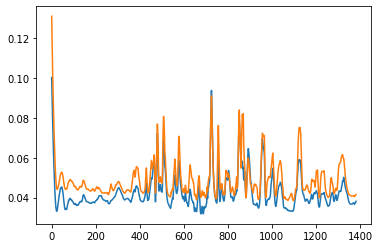

In [7]:
plt.plot(val_loss_hist)
plt.plot(test_loss_hist)

In [8]:
np.argmin(val_loss_hist)

678

In [9]:
np.min(val_loss_hist)

0.03182900598538774

In [11]:
test_loss_hist[678]

0.04018440646220847